### Complete task:
1) Find texts about cats, add 100+ random entries with text about cats and change its label to "Cat".You can add 'cats texts' to already used dataset in the notebook example
2) Train the model to classify and catch texts about cats


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

### Prepare the task-specific data

In [30]:
df = pd.read_excel('CATS_DOGS.xlsx')

In [31]:
df

,NAME,SENTENCE
0,cat,"Cats are curious creatures, always exploring t..."
1,cat,Their whiskers are sensitive tools that help t...
2,cat,"Cats are expert groomers, meticulously cleanin..."
3,cat,They have sharp retractable claws that they us...
4,cat,"Cats are natural hunters, with keen senses of ..."
...,...,...
195,dog,Demonstrating empathy and understanding toward...
196,dog,Exhibiting curiosity and eagerness to explore ...
197,dog,Communicating emotions and intentions through ...
198,dog,Known for their intelligence and ability to le...


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NAME      200 non-null    object
 1   SENTENCE  200 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


<Axes: >

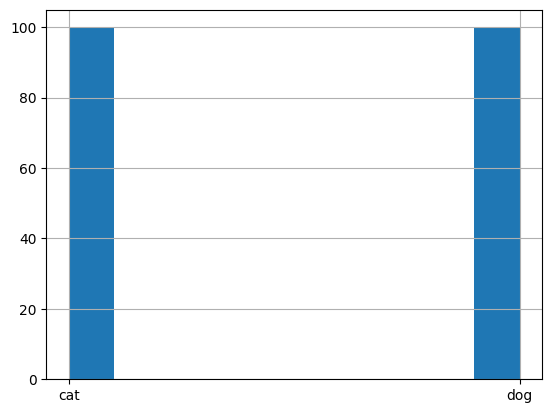

In [33]:
df['NAME'].hist()

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['TARGET'] = label_encoder.fit_transform(df['NAME'])
df

,NAME,SENTENCE,TARGET
0,cat,"Cats are curious creatures, always exploring t...",0
1,cat,Their whiskers are sensitive tools that help t...,0
2,cat,"Cats are expert groomers, meticulously cleanin...",0
3,cat,They have sharp retractable claws that they us...,0
4,cat,"Cats are natural hunters, with keen senses of ...",0
...,...,...,...
195,dog,Demonstrating empathy and understanding toward...,1
196,dog,Exhibiting curiosity and eagerness to explore ...,1
197,dog,Communicating emotions and intentions through ...,1
198,dog,Known for their intelligence and ability to le...,1


In [35]:
df1 = df[['SENTENCE','TARGET']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [36]:
from datasets import load_dataset
# Uses the “load_dataset” function to load a dataset stored in a CSV file named “data.csv”, which we have stored above.
raw_dataset = load_dataset('csv', data_files = 'data.csv')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 200 examples [00:00, 16681.13 examples/s]


In [37]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 200
    })
})

In [39]:
split = raw_dataset['train'].train_test_split(test_size=0.25, seed=2024)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 150
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 50
    })
})

### Tokenize the data

In [40]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased' #choose the model
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [41]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [42]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map: 100%|██████████| 50/50 [00:00<00:00, 1042.52 examples/s]


In [44]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [45]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [47]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [48]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [49]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [50]:
trainer.train()

                                               
 33%|███▎      | 10/30 [00:02<00:03,  6.17it/s]

{'eval_loss': 0.12852945923805237, 'eval_accuracy': 1.0, 'eval_f1_score': 1.0, 'eval_runtime': 0.1638, 'eval_samples_per_second': 305.19, 'eval_steps_per_second': 6.104, 'epoch': 1.0}


                                               
 67%|██████▋   | 20/30 [00:06<00:02,  4.99it/s]

{'eval_loss': 0.08665881305932999, 'eval_accuracy': 0.98, 'eval_f1_score': 0.98, 'eval_runtime': 0.1558, 'eval_samples_per_second': 320.856, 'eval_steps_per_second': 6.417, 'epoch': 2.0}


                                               
100%|██████████| 30/30 [00:11<00:00,  4.86it/s]

{'eval_loss': 0.0885637104511261, 'eval_accuracy': 0.98, 'eval_f1_score': 0.98, 'eval_runtime': 0.1638, 'eval_samples_per_second': 305.19, 'eval_steps_per_second': 6.104, 'epoch': 3.0}


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]

{'train_runtime': 14.2645, 'train_samples_per_second': 31.547, 'train_steps_per_second': 2.103, 'train_loss': 0.15761202176411945, 'epoch': 3.0}


TrainOutput(global_step=30, training_loss=0.15761202176411945, metrics={'train_runtime': 14.2645, 'train_samples_per_second': 31.547, 'train_steps_per_second': 2.103, 'train_loss': 0.15761202176411945, 'epoch': 3.0})

### Get predictions

In [52]:
%ls training_dir

 Volume in drive D is DATA
 Volume Serial Number is 268B-7811

 Directory of d:\Amazinuum\lesson35\training_dir

17.03.2024  01:43    <DIR>          .
17.03.2024  01:43    <DIR>          ..
17.03.2024  01:43    <DIR>          checkpoint-10
17.03.2024  01:43    <DIR>          checkpoint-20
17.03.2024  01:43    <DIR>          checkpoint-30
17.03.2024  01:43    <DIR>          runs
               0 File(s)              0 bytes
               6 Dir(s)  251�179�634�688 bytes free


In [53]:
from transformers import pipeline

In [54]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-30')

In [55]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 50
})

In [56]:
predictions = saved_model(split['test']['sentence'])

In [57]:
predictions[:10]

[{'label': 'LABEL_1', 'score': 0.9839216470718384},
 {'label': 'LABEL_0', 'score': 0.9893691539764404},
 {'label': 'LABEL_1', 'score': 0.983869731426239},
 {'label': 'LABEL_1', 'score': 0.8776712417602539},
 {'label': 'LABEL_1', 'score': 0.9837448596954346},
 {'label': 'LABEL_1', 'score': 0.9836013913154602},
 {'label': 'LABEL_0', 'score': 0.9892095923423767},
 {'label': 'LABEL_0', 'score': 0.9894304275512695},
 {'label': 'LABEL_0', 'score': 0.9892529845237732},
 {'label': 'LABEL_0', 'score': 0.9892095923423767}]

In [58]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [59]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.98


In [60]:
#Calculate f1 score
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.9796001631986944


### Plot confusion matrix

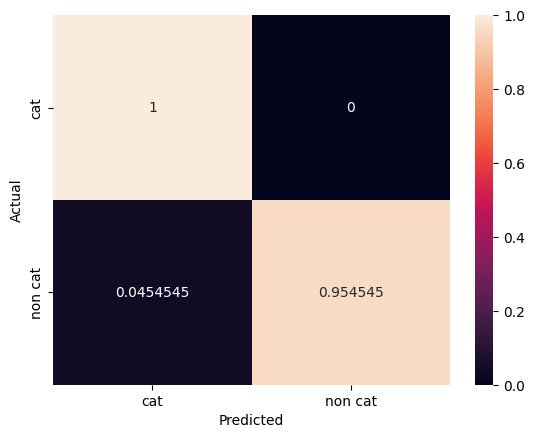

In [62]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['cat','non cat']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)